In [9]:
# Imports
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.datasets import fetch_401K

import torch
import os
import time
from functools import partial

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Causal_cocycle imports
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.distribution_estimation import ConditionalExpectationRegressor  # :contentReference[oaicite:5]{index=5}
from causal_cocycle.regression_functionals import NWFunctional
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.conditioners_new import RFConditioner,NWConditioner  # NWConditioner defined earlier
from causal_cocycle.transformers_new import KREpsLayer  # Your KR transformer layer
from causal_cocycle.model_new import CocycleModel   # Your CocycleModel class
from e401k_cocycle_config import model_config, opt_config

In [2]:
# Getting data and names
Data = fetch_401K(return_type='DataFrame')
data = Data.to_numpy()
names = np.array(list(Data[:0]))

In [3]:
"""
Data processing
"""

# Names
covariates = ['age', 'inc', 'educ', 'fsize', 'marr',
                 'twoearn', 'db', 'pira', 'hown', 'e401']
treatment = ["e401"]
outcome = ["net_tfa"]

# Creating tensors
X = Data[Data.columns.intersection(covariates)]
names_x = np.array(list(X[:0]))
treatment_ind = np.where(names_x == "e401")[0][0]
X = X.to_numpy()
cols_order = ([treatment_ind]+
              list(np.linspace(0,treatment_ind-1,treatment_ind).astype(int))+
              list(np.linspace(treatment_ind+1,len(X.T)-1,len(X.T)-1-treatment_ind).astype(int)))
X = X[:,cols_order]
N = len(X)
D = len(X.T)
Y = Data[Data.columns.intersection(outcome)].to_numpy().reshape(N,)
X,Y = torch.tensor(X),torch.tensor(Y).view(N,1)
print("# treated = ", int(X[:,0].sum()), "/", N)

# Scaling data
scale_X = torch.ones(len(X.T))
for i in range(len(X.T)):
    if len(torch.unique(X[:,i])) > 2:
        scale_X[i] = X[:,i].var(0)**0.5
scale_Y = Y.var(0)**0.5
Xscale,Yscale = X/scale_X, Y/scale_Y

# Random dataset shuffle
id = torch.randperm(Xscale.size(0))
Xscale,Yscale = Xscale[id].double(),Yscale[id].double()

# Train validation split
train_pc = 0.7
ntrain = int(train_pc * N)
Xtr, Ytr = Xscale[:ntrain], Yscale[:ntrain]
Xte, Yte = Xscale[ntrain:], Yscale[ntrain:]

Xscale.mean(0), Yscale.mean()

# treated =  3682 / 9915


(tensor([0.3714, 3.9693, 1.5016, 1.8622, 4.6991, 0.2710, 0.6048, 0.3808, 0.2422,
         0.6352], dtype=torch.float64),
 tensor(0.2842, dtype=torch.float64))

In [46]:
"""
Conditional CDF estimation
"""

param_grid = {
    'n_estimators': [500],
    'max_depth': [2,10,50,100],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt']  # 'auto' is not allowed for RF regressor; 'sqrt' is common
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(Xtr, Ytr.squeeze(-1))
print("Best hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

# Refit on the full training set
best_rf.fit(Xtr, Ytr.squeeze(-1))

Best hyperparameters from GridSearchCV:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500}


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=500, random_state=42)

In [47]:
"""
KRcocycle construction + loss for CMMD
"""

# Getting sorted data + epsilon
Ysort,ids = torch.sort(Ytr.squeeze().double())
Xsort = Xtr[ids].double()
diff_unique = (Ysort[1:] - Ysort[:-1]).unique()
epsilon = min(1e-6, (diff_unique)[diff_unique!=0].min()/10)
print(epsilon)

# Construct cocycle model
conditioner = RFConditioner(best_rf, Xsort.numpy(), Ysort.numpy())
transformer = KREpsLayer(Ysort, epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)

# Construct loss
kernel_loss = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel_loss)
loss = loss_factory.build_loss("CMMD_V", Ytr, Ytr, subsamples=10**4)

1e-06


In [50]:
"""
Getting validation loss on test data
"""
def cmmd_embedding_loss_vectorized(model, X, Y, kernel, batchsize=10):
    """
    Fully vectorized CMMD loss with batch processing over i.

    Args:
        model: with .inverse_transformation(X, Y), .transformation(X, Z)
        X: (n, d)
        Y: (n, p)
        kernel: with get_gram(A, B)
        batchsize: outer batch size

    Returns:
        scalar CMMD loss
    """
    import torch, gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # Step 1: precompute base latent samples Z = f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # shape: (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]      # shape: (b, d)
        Y_i = Y[i_start:i_end]      # shape: (b, p)

        # Step 2: expand X_i to match (b x n) for transformation
        X_i_repeat = X_i[:, None, :].repeat(1, n, 1).reshape(b * n, -1)   # (b*n, d)
        Z_repeat = Z_base[None, :, :].repeat(b, 1, 1).reshape(b * n, -1)  # (b*n, p)

        # Step 3: transform → Y_hat[i, j, :] = f_{x_i}(Z_j)
        with torch.no_grad():
            Y_hat = model.transformation(X_i_repeat, Z_repeat).detach().reshape(b, n, -1)  # (b, n, p)

        # Step 4: Compute CMMD loss terms vectorized
        k_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
        k_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).nanmean()
            for i in range(b)
        ])
        k_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).nanmean()
            for i in range(b)
        ])

        loss_batch = k_yy_diag + k_hat_hat - 2 * k_y_hat
        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n


cmmd = cmmd_embedding_loss_vectorized(model,Xte.double(),Yte.double(),loss.kernel[-1])
print("CMMD is ", cmmd)

Precomputing inverse-transformed base samples...
[90/2975] Memory used (MB): 1042.12
[100/2975] Memory used (MB): 1036.32
[110/2975] Memory used (MB): 1036.77
[120/2975] Memory used (MB): 1036.79
[130/2975] Memory used (MB): 1043.17
[140/2975] Memory used (MB): 1035.44
[150/2975] Memory used (MB): 1040.75
[160/2975] Memory used (MB): 1040.78
[170/2975] Memory used (MB): 1039.95
[180/2975] Memory used (MB): 1039.74
[190/2975] Memory used (MB): 1040.98
[200/2975] Memory used (MB): 1039.41
[210/2975] Memory used (MB): 1037.83
[220/2975] Memory used (MB): 1040.54
[230/2975] Memory used (MB): 1036.13
[240/2975] Memory used (MB): 1037.79
[250/2975] Memory used (MB): 1037.02
[260/2975] Memory used (MB): 1038.46
[270/2975] Memory used (MB): 1033.33
[280/2975] Memory used (MB): 1041.03
[290/2975] Memory used (MB): 1039.99
[300/2975] Memory used (MB): 1042.01
[310/2975] Memory used (MB): 1040.98
[320/2975] Memory used (MB): 1038.62
[330/2975] Memory used (MB): 1038.35
[340/2975] Memory used (MB)

In [51]:
cmmd

tensor(0.4700, dtype=torch.float64)

In [37]:
"""
Fitting final model on full data
"""

# Refit on the full training set
best_rf.fit(Xscale, Yscale.squeeze(-1))

# Getting sorted data + epsilon
Ysort,ids = torch.sort(Yscale.squeeze().double())
Xsort = Xscale[ids].double()
diff_unique = (Ysort[1:] - Ysort[:-1]).unique()
epsilon = min(1e-6, (diff_unique)[diff_unique!=0].min()/10)
print(epsilon)

# Construct cocycle model
conditioner = RFConditioner(best_rf, Xsort.numpy(), Ysort.numpy())
transformer = KREpsLayer(Ysort, epsilon)
model = CocycleModel(conditioner=conditioner, transformer=transformer)

1e-06


In [38]:
"""
Getting predictions
"""
X0scale,X1scale = Xscale*1,Xscale*1
X0scale[:,0] = 0
X1scale[:,0] = 1
Y0scale = model.cocycle(X0scale,Xscale,Yscale).detach()
Y1scale = model.cocycle(X1scale,Xscale,Yscale).detach()

ATE = (Y1scale-Y0scale).mean()*scale_Y
ATT = (Y1scale[Xscale[:,0]==1]-Y0scale[Xscale[:,0]==1]).mean()*scale_Y
print("ATE : ", ATE.item())
print("ATT : ", ATT.item())

In [60]:
print("ATE : ", ATE.item())
print("ATT : ", ATT.item())

ATE :  7796.98193359375
ATT :  11618.634765625


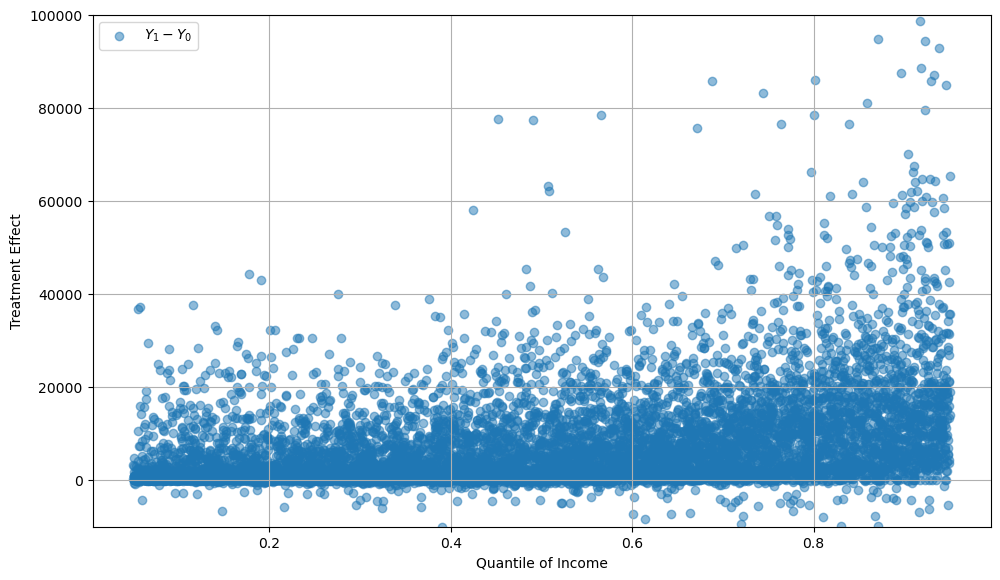

In [73]:
"""
Quantile plot
"""
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
V = Xscale[:,2:3]
sort_idx = np.argsort(V.squeeze(-1))
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
quantile_positions = np.linspace(0, 1, N)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", alpha = 0.5)
plt.xlabel("Quantile of Income")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.tight_layout()
#plt.yscale("log")
plt.ylim(-10000,100000)
plt.legend()
plt.show()

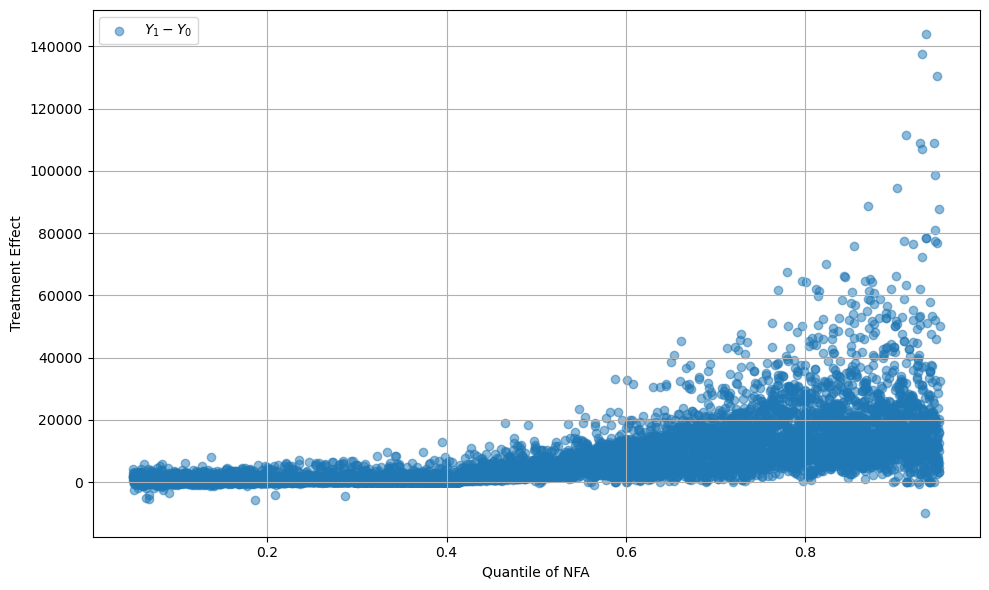

In [72]:
"""
Quantile plot
"""
import numpy as np
import matplotlib.pyplot as plt

# Assume Y0scale and Y1scale are 1D numpy arrays of equal length
Y_diff = (Y1scale - Y0scale)

# Step 1: Sort Y0scale and get corresponding sorted Y_diff
sort_idx = np.argsort(Y0scale.squeeze(-1))
Y0_sorted = Y0scale[sort_idx]
Y_diff_sorted = Y_diff[sort_idx]

# Step 2: Compute quantile positions (from 0 to 1)
n = len(Y0scale)
quantile_positions = np.linspace(0, 1, n)

# Step 3: Plot
plt.figure(figsize=(10, 6))
l = int(n/20)
plt.scatter(quantile_positions[l:n-l], Y_diff_sorted[l:n-l]*scale_Y, label="$Y_1 - Y_0$", alpha = 0.5)
plt.xlabel("Quantile of NFA")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [127]:
"""
Train NW functional for conditional distribution 
"""
kernel_V = GaussianKernel(lengthscale=torch.ones(1))
functional_V = NWFunctional(kernel=kernel_V, reg=0.0)
CER_V = ConditionalExpectationRegressor(functional_V)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100, dtype = torch.float64))
feature_ = ((Y1scale - Y0scale).unsqueeze(-1)<= test_points_.unsqueeze(0)).float()
losses_V = CER_V.optimise(V.argsort(0).argsort(0)/N, feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

kernel_Y0 = GaussianKernel(lengthscale=torch.ones(1))
functional_Y0 = NWFunctional(kernel=kernel_Y0, reg=0.0)
CER_Y0 = ConditionalExpectationRegressor(functional_Y0)
print("Starting hyperparameter optimisation...")
test_points_ = torch.quantile(Y1scale - Y0scale, torch.linspace(0,1,100, dtype = torch.float64))
feature_ = ((Y1scale - Y0scale).unsqueeze(-1)<= test_points_.unsqueeze(0)).float()
losses_Y0 = CER_Y0.optimise(Y0scale.unsqueeze(-1).argsort(0).argsort(0)/N, feature_, maxiter=1000, nfold=5, learn_rate=1e-1, print_=True, subsamples = 256)

Starting hyperparameter optimisation...
[iter 0] avg CV loss: 0.161393
lengthscale: tensor([0.9048], grad_fn=<ExpBackward0>)
[iter 10] avg CV loss: 0.148406
lengthscale: tensor([0.3265], grad_fn=<ExpBackward0>)
[iter 20] avg CV loss: 0.141695
lengthscale: tensor([0.1347], grad_fn=<ExpBackward0>)
[iter 30] avg CV loss: 0.141152
lengthscale: tensor([0.0894], grad_fn=<ExpBackward0>)
[iter 40] avg CV loss: 0.141898
lengthscale: tensor([0.0824], grad_fn=<ExpBackward0>)
[iter 50] avg CV loss: 0.140893
lengthscale: tensor([0.0891], grad_fn=<ExpBackward0>)
[iter 60] avg CV loss: 0.141420
lengthscale: tensor([0.1004], grad_fn=<ExpBackward0>)
[iter 70] avg CV loss: 0.140874
lengthscale: tensor([0.1113], grad_fn=<ExpBackward0>)
[iter 80] avg CV loss: 0.140862
lengthscale: tensor([0.1195], grad_fn=<ExpBackward0>)
[iter 90] avg CV loss: 0.141422
lengthscale: tensor([0.1221], grad_fn=<ExpBackward0>)
[iter 100] avg CV loss: 0.140790
lengthscale: tensor([0.1195], grad_fn=<ExpBackward0>)
[iter 110] avg

In [170]:
""" 
Defining model of conditional distribution + predicting quantiles
"""
ntest = 500
quantiles = torch.tensor([[0.025,0.05,0.25,0.5,0.75,0.95,0.975]]).T
diff_sorted,ids = (Y1scale-Y0scale).squeeze(-1).sort()
Y0sorted = Y0scale[ids]
Vsorted = V[ids]

conditioner_V = NWConditioner(Vsorted.argsort(0).argsort(0).double()/N, kernel_V)
conditioner_Y0 = NWConditioner(Y0sorted.argsort().argsort().unsqueeze(-1).double()/N, kernel_Y0)
transformer_ = KREpsLayer(diff_sorted, epsilon = 0)

Y0test = torch.linspace(0.1,0.9,ntest, dtype = torch.float64).unsqueeze(-1)
Vtest = torch.linspace(0.1,0.9,ntest, dtype = torch.float64).unsqueeze(-1)
weights_V = conditioner_V.forward(Vtest)
weights_Y0 = conditioner_Y0.forward(Y0test)
quantile_preds_V = torch.zeros((len(quantiles),ntest))
quantile_preds_Y0 = torch.zeros((len(quantiles),ntest))
for i in range(ntest):
    quantile_preds_V[:,i] = transformer_.forward(weights_V[i:i+1].repeat(len(quantiles),1), quantiles)
    quantile_preds_Y0[:,i] = transformer_.forward(weights_Y0[i:i+1].repeat(len(quantiles),1), quantiles)

mu_preds_V = functional_V.forward((Y1scale-Y0scale).unsqueeze(-1),V.argsort(0).argsort(0).double()/N, Vtest)
mu_preds_Y0 = functional_Y0.forward((Y1scale-Y0scale).unsqueeze(-1),Y0scale.argsort().argsort().double().unsqueeze(-1)/N, Y0test)

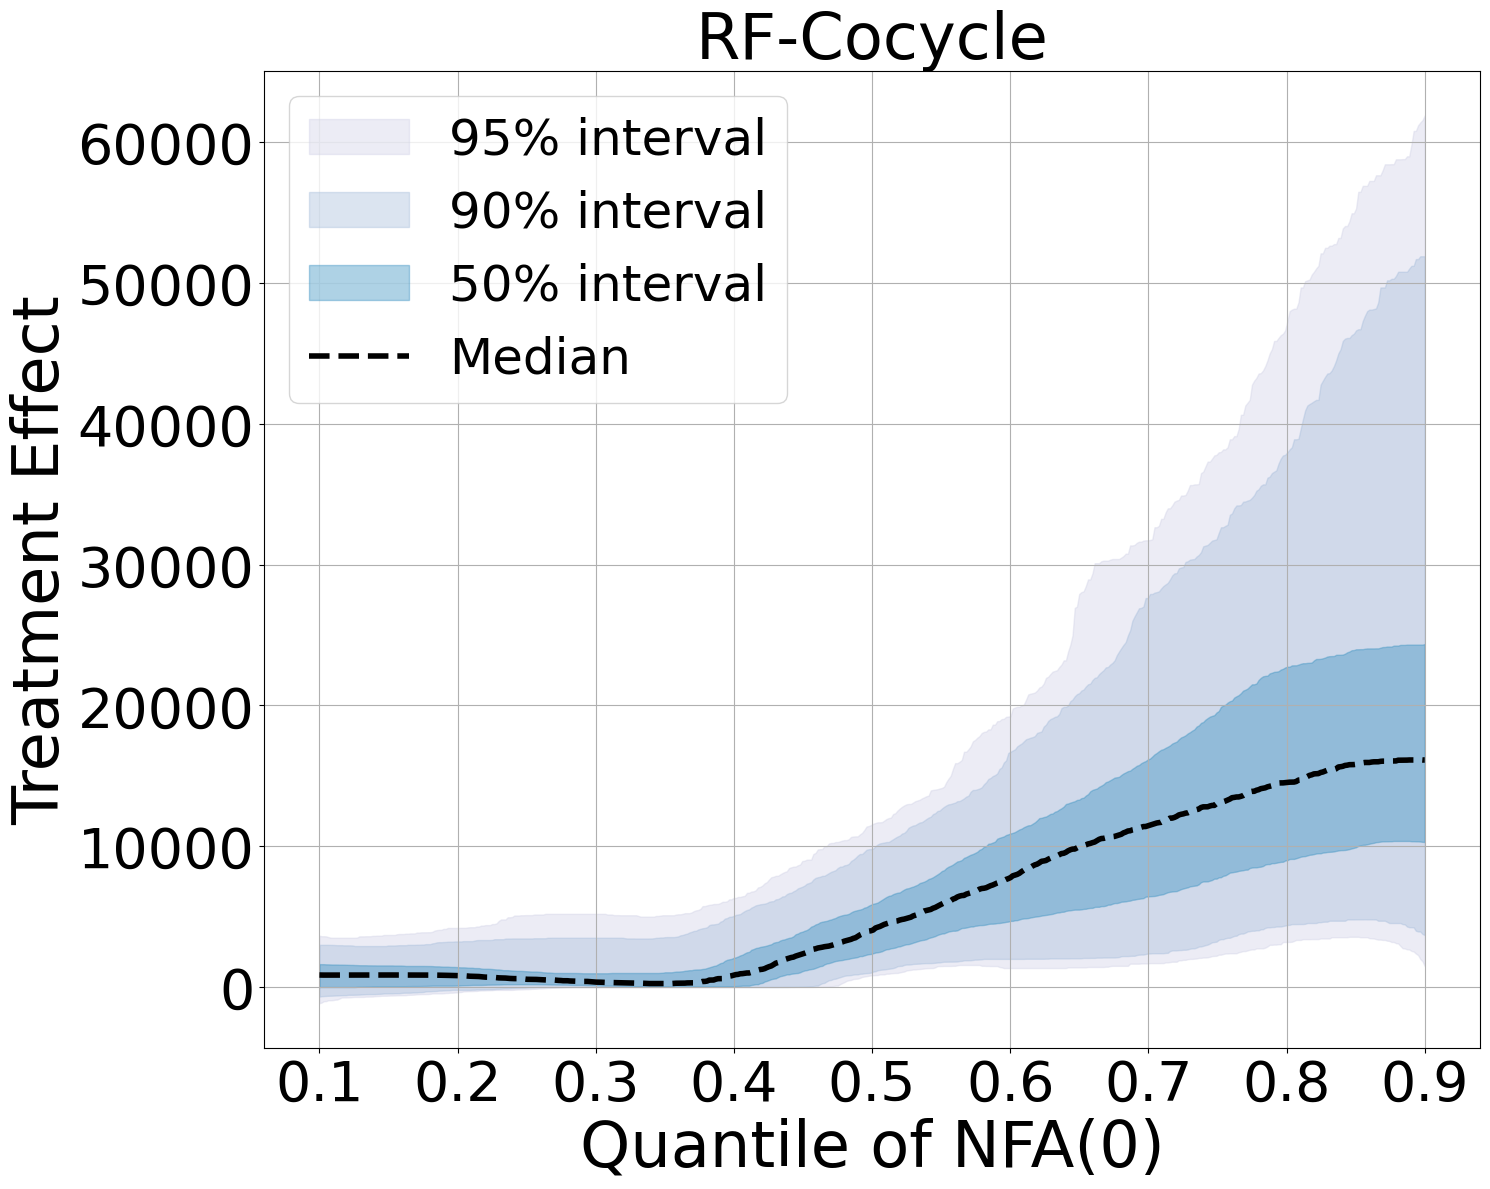

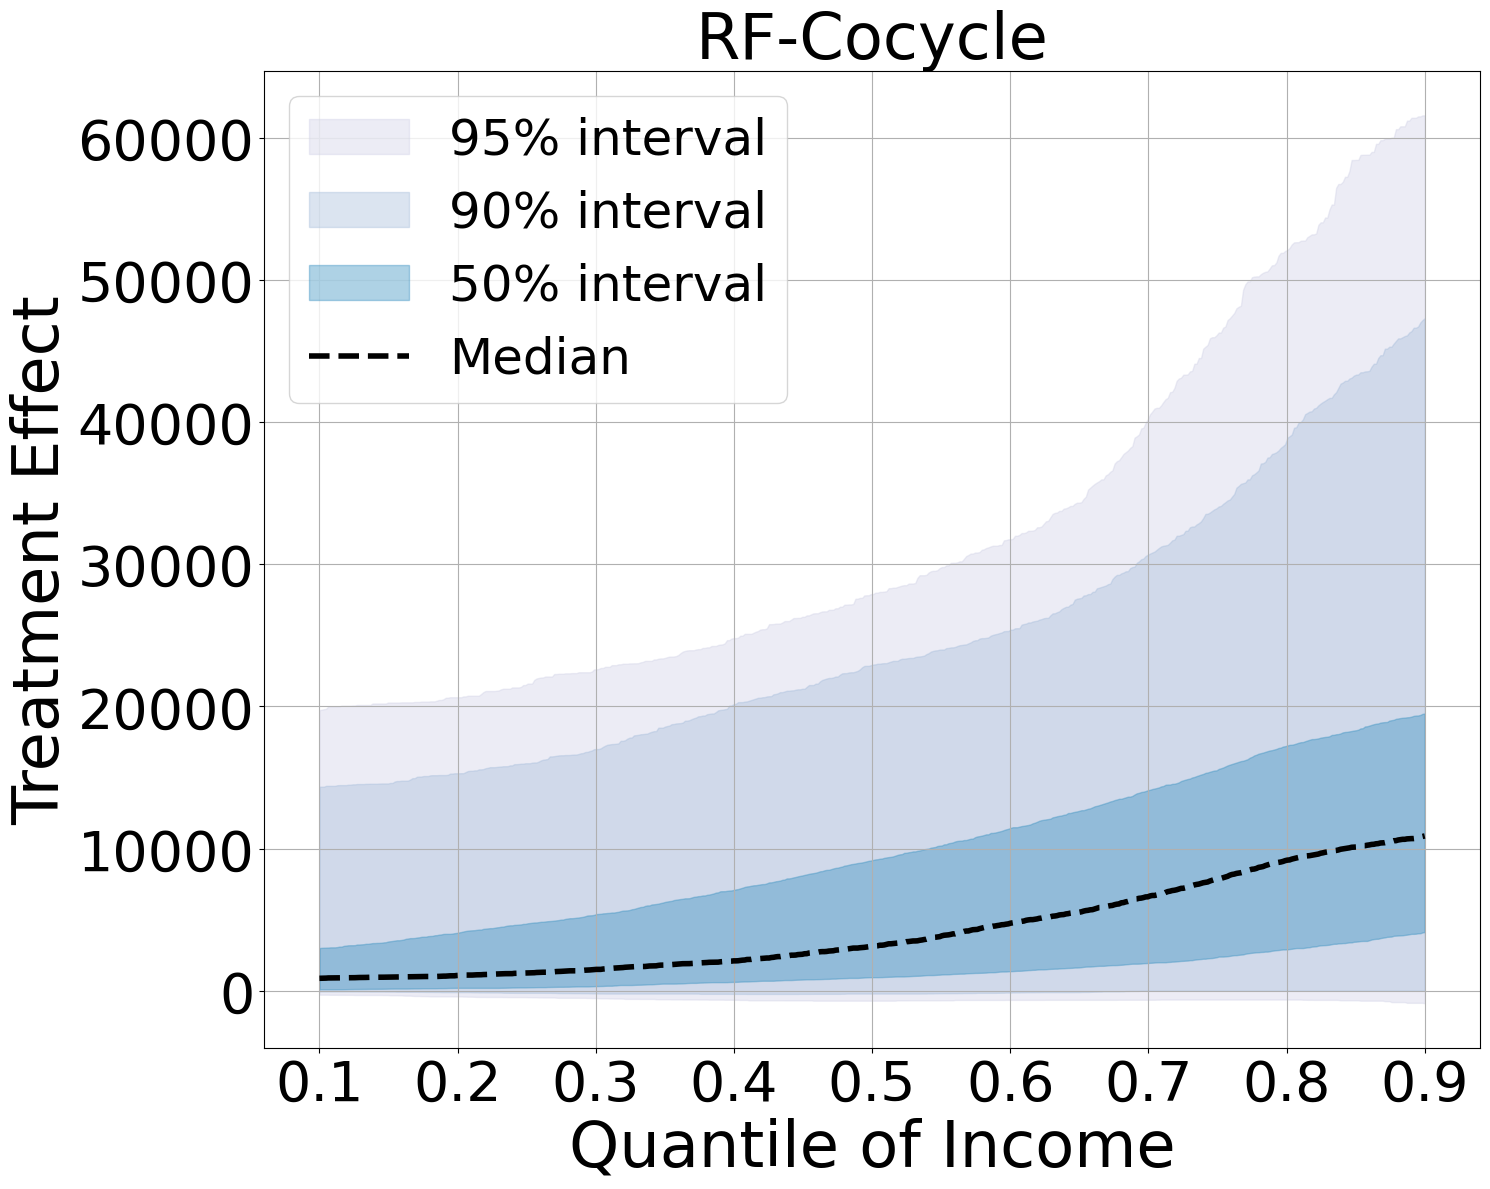

In [171]:
"""
Plotting Results
"""
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds_Y0.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.025, 0.975), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100+0.1)}% interval')

# Add the median quantile curve
plt.plot(x,qmap[0.5]*scale_Y.item(), color='black', lw=4.0, label='Median', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of NFA(0)', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'RF-Cocycle', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_krcocycle_rf_NFA.png", bbox_inches = "tight")
plt.show()

"""
Plotting Results
"""
import matplotlib.pyplot as plt

# Set up axis labels
x = torch.linspace(0.1, 0.9, ntest, dtype=torch.float64).numpy()
q = quantile_preds_V.detach().numpy()  # shape: (n_q, ntest)

# Define quantile levels for shaded regions
quantile_levels = [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]
qmap = {level: q[i] for i, level in enumerate(quantile_levels)}

# Create figure with doubled size
plt.figure(figsize=(15, 12))

# Fill between symmetric quantiles
fill_pairs = [(0.025, 0.975), (0.05, 0.95), (0.25, 0.75)]
colors = ['#d0d1e6', '#a6bddb', '#3690c0']  # lighter to darker

for (lo, hi), color in zip(fill_pairs, colors):
    plt.fill_between(x, qmap[lo]*scale_Y.item(), qmap[hi]*scale_Y.item(), alpha=0.4, color=color,
                     label=f'{int((hi - lo)*100+0.1)}% interval')

# Add the median quantile curve
plt.plot(x,qmap[0.5]*scale_Y.item(), color='black', lw=4.0, label='Median', ls="dashed")

# Final formatting
plt.xlabel(r'Quantile of Income', fontsize=46)
plt.ylabel('Treatment Effect', fontsize=46)
plt.title(r'RF-Cocycle', fontsize=46)
plt.legend(fontsize=36, loc = 'upper left')
plt.grid(True)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig("e401k_krcocycle_rf_income.png", bbox_inches = "tight")
plt.show()

In [48]:
import psutil, os
def cmmd_embedding_loss(model, X, Y, kernel, batchsize=10):
    """
    Computes the CMMD loss correctly via kernel trick:
      CMMD = (1/n) * sum_i || psi(Y_i) - (1/n) sum_j psi(T_{X_i,X_j}(Y_j)) ||^2
    without forming psi explicitly.

    Args:
        model: must have .cocycle(X_i, X_j, Y_j)
        X: (n, d)
        Y: (n, p)
        kernel: kernel object with get_gram(Y1, Y2)
        batchsize: number of outer-loop samples (i) to process

    Returns:
        scalar CMMD loss (torch tensor)
    """
    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        # Get batch of X_i and Y_i
        X_i = X[i_start:i_end]       # (b, d)
        Y_i = Y[i_start:i_end]       # (b, p)

        # Repeat X_i n times to match (i, j)
        X_i_repeat = X_i.unsqueeze(1).repeat(1, n, 1).reshape(b * n, -1)  # (b*n, d)
        X_j = X.repeat(b, 1)                                            # (b*n, d)
        Y_j = Y.repeat(b, 1)                                            # (b*n, p)

        # Apply transport: T_{X_i, X_j}(Y_j)
        Y_hat = model.cocycle(X_i_repeat, X_j, Y_j)  # (b*n, p)
        Y_hat = Y_hat.view(b, n, -1)  # (b, n, p)

        # --- Compute CMMD terms via kernel trick ---

        # Term 1: k(Y_i, Y_i)
        K_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)

        # Term 2: (1/n^2) sum_{j,j'} k(Ŷ_{ij}, Ŷ_{ij'})
        K_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).mean()
            for i in range(b)
        ])  # (b,)

        # Term 3: (1/n) sum_j k(Y_i, Ŷ_{ij})
        K_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).mean()
            for i in range(b)
        ])  # (b,)

        # Combine terms
        loss_batch = K_yy_diag + K_hat_hat - 2 * K_y_hat
        total_loss += loss_batch.sum()

        print(f"Memory used (MB): {psutil.Process(os.getpid()).memory_info().rss / 1e6}")

    return total_loss / n

def cmmd_embedding_loss_optimized(model, X, Y, kernel, batchsize=10):
    """
    Computes CMMD loss:
        CMMD = (1/n) sum_i || ψ(Y_i) - (1/n) sum_j ψ(T_{x_i, x_j}(Y_j)) ||^2

    where T_{x_i, x_j}(Y_j) = f_{x_i} ( f_{x_j}^{-1}(Y_j) )

    Args:
        model: has .inverse_transformation(Y, X), .transformation(Y, X), .conditioner(X)
        X: (n, d)
        Y: (n, p)
        kernel: with .get_gram(A, B)
        batchsize: number of i's per batch

    Returns:
        scalar torch.Tensor
    """
    import gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # ✅ Precompute base samples: f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]     # (b, d)
        Y_i = Y[i_start:i_end]     # (b, p)
        loss_batch = torch.zeros(b, device=device)

        for i in range(b):
            xi = X_i[i:i+1]        # (1, d)
            yi = Y_i[i:i+1]        # (1, p)

            # Compute transported samples: T_{xi, xj}(Y_j) = f_{xi}(Z_base)
            xi_repeat = xi.repeat(n, 1)  # (n, d)
            with torch.no_grad():
                Y_hat = model.transformation(xi_repeat,Z_base).detach().unsqueeze(-1)  # (n, p)
            # Compute kernel terms
            k_yy = kernel.get_gram(yi, yi).item()
            k_hat_hat = kernel.get_gram(Y_hat, Y_hat).nanmean().item()
            k_y_hat = kernel.get_gram(yi, Y_hat).nanmean().item()

            loss_i = k_yy + k_hat_hat - 2 * k_y_hat
            loss_batch[i] = loss_i

        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n

def cmmd_embedding_loss_vectorized(model, X, Y, kernel, batchsize=10):
    """
    Fully vectorized CMMD loss with batch processing over i.

    Args:
        model: with .inverse_transformation(X, Y), .transformation(X, Z)
        X: (n, d)
        Y: (n, p)
        kernel: with get_gram(A, B)
        batchsize: outer batch size

    Returns:
        scalar CMMD loss
    """
    import torch, gc, psutil, os

    n = X.shape[0]
    device = X.device
    total_loss = 0.0

    # Step 1: precompute base latent samples Z = f^{-1}_{x_j}(Y_j)
    print("Precomputing inverse-transformed base samples...")
    with torch.no_grad():
        Z_base = model.inverse_transformation(X, Y).detach()  # shape: (n, p)

    for i_start in range(0, n, batchsize):
        i_end = min(i_start + batchsize, n)
        b = i_end - i_start

        X_i = X[i_start:i_end]      # shape: (b, d)
        Y_i = Y[i_start:i_end]      # shape: (b, p)

        # Step 2: expand X_i to match (b x n) for transformation
        X_i_repeat = X_i[:, None, :].repeat(1, n, 1).reshape(b * n, -1)   # (b*n, d)
        Z_repeat = Z_base[None, :, :].repeat(b, 1, 1).reshape(b * n, -1)  # (b*n, p)

        # Step 3: transform → Y_hat[i, j, :] = f_{x_i}(Z_j)
        with torch.no_grad():
            Y_hat = model.transformation(X_i_repeat, Z_repeat).detach().reshape(b, n, -1)  # (b, n, p)

        # Step 4: Compute CMMD loss terms vectorized
        k_yy_diag = torch.diagonal(kernel.get_gram(Y_i, Y_i))  # (b,)
        k_y_hat = torch.stack([
            kernel.get_gram(Y_i[i:i+1], Y_hat[i]).nanmean()
            for i in range(b)
        ])
        k_hat_hat = torch.stack([
            kernel.get_gram(Y_hat[i], Y_hat[i]).nanmean()
            for i in range(b)
        ])

        loss_batch = k_yy_diag + k_hat_hat - 2 * k_y_hat
        total_loss += loss_batch.sum()

        mem_MB = psutil.Process(os.getpid()).memory_info().rss / 1e6
        print(f"[{i_end}/{n}] Memory used (MB): {mem_MB:.2f}")
        gc.collect()
        torch.cuda.empty_cache()

    return total_loss / n